In [11]:
#https://www.kaggle.com/code/alifvianmarco/covid-19-in-indonesia

import os
import numpy as np
import pandas as pd
import random
import seaborn as sns

import datetime as datetime
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

import datetime
from datetime import date

In [20]:
data = pd.read_csv('./data/regional_cleaned.csv', index_col=0)
data.head(20)

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Area (km2),Population,Population Density,Increasing
0,2020-03-01,DKI Jakarta,2.0,0.0,0.0,2,39,20,41,-22,664,10846145,16334.31,0
1,2020-03-02,Riau,1.0,0.0,0.0,1,2,0,3,-1,87024,6074100,69.80,0
2,2020-03-02,DKI Jakarta,2.0,0.0,0.0,2,41,20,41,-20,664,10846145,16334.31,1
3,2020-03-03,DKI Jakarta,2.0,0.0,0.0,2,43,20,41,-18,664,10846145,16334.31,1
4,2020-03-03,Riau,0.0,0.0,0.0,0,2,0,3,-1,87024,6074100,69.80,0
5,2020-03-03,Jawa Barat,1.0,1.0,0.0,0,1,1,8,-8,35378,45161325,1276.55,0
6,2020-03-04,DKI Jakarta,2.0,0.0,0.0,2,45,20,41,-16,664,10846145,16334.31,1
7,2020-03-04,Jawa Barat,1.0,0.0,0.0,1,2,1,8,-7,35378,45161325,1276.55,1
8,2020-03-04,Riau,0.0,0.0,0.0,0,2,0,3,-1,87024,6074100,69.80,0
9,2020-03-05,Riau,0.0,0.0,0.0,0,2,0,3,-1,87024,6074100,69.80,0


In [22]:
X = data.drop(['New Deaths', "Date", "Location"], axis = 1)
y = data['New Deaths']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 41)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15837, 11)
(5280, 11)
(15837,)
(5280,)


In [24]:
pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [25]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')

In [26]:
def predict_model(model, trainX, testX, trainY, testY):
    m = model
    m.fit(trainX, trainY)
    predict_m = m.predict(testX)
    print('-----------{}-----------'.format(model))
    print_evaluate(testY, predict_m)

In [27]:
model = [LinearRegression(),SVR()]
for i in model:
    predict_model(i, X_train,X_test, y_train, y_test)

-----------LinearRegression()-----------
MAE: 4.586022606277736
MSE: 258.7510784509013
RMSE: 16.08574146413218
R2 Square 0.5853144190907653
__________________________________
-----------SVR()-----------
MAE: 4.070569072989225
MSE: 450.00934160068266
RMSE: 21.213423618093394
R2 Square 0.278795719988964
__________________________________


MAE: 4.070569072989225
MSE: 450.00934160068266
RMSE: 21.213423618093394
R2 Square 0.278795719988964
__________________________________


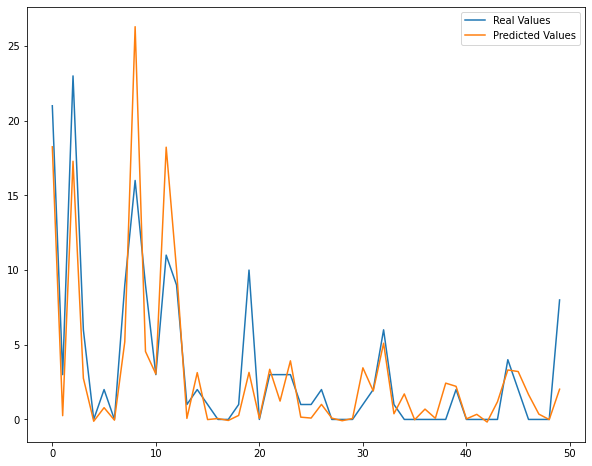

In [28]:
dct = SVR()
dct.fit(X_train, y_train)

pred_dct = dct.predict(X_test)
print_evaluate(y_test, pred_dct)

df_dct = pd.DataFrame({'Real Values':y_test, 'Predicted Values':pred_dct})
df_dct.head()

plt.figure(figsize=(10,8))
plt.plot(df_dct['Real Values'].values[:50], label = 'Real Values')
plt.plot(df_dct['Predicted Values'].values[:50], label = 'Predicted Values')
plt.legend()
plt.show()